In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
horizon = 25
alpha = 0.42
env = gym.make("cpr_gym_rs:Nakamoto-v0", alpha=alpha, horizon=horizon)

In [3]:
def do_nothing_policy(o):
    return env.unwrapped.encode_action_continue()


def honest_policy(o):
    assert o.shape == (5,)
    release = o[-2]
    consider = o[-1]
    if release < 0:
        return [release]
    if consider > 0:
        return [consider]
    return [0]  # continue


def selfish_mining_policy(o):
    assert o.shape == (5,)
    a = o[0]
    h = o[1]
    if h > a:
        return env.unwrapped.encode_action_consider(0)  # adopt
    if a == 1 and h == 1:
        return env.unwrapped.encode_action_release(0)  # match
    if h == a - 1 and h >= 1:
        return env.unwrapped.encode_action_release(0)  # override
    return env.unwrapped.encode_action_continue()  # continue / wait


_ = env.reset()
_, _, _, _, info = env.step(env.unwrapped.encode_action_continue())
keys = sorted(info.keys())


def simulate(policy, label):
    episodes = []

    def ep_dict():
        d = dict(steps=0)
        for k in keys:
            d[k] = 0
        return d

    def acc_dict(d, info):
        d["steps"] += 1
        for k in keys:
            d[k] += info[k]

    ep = ep_dict()
    obs, info = env.reset()
    for i in range(50000):
        a = policy(obs)
        obs, r, term, trunc, info = env.step(a)
        acc_dict(ep, info)
        if term or trunc:
            episodes.append(dict(policy=label) | ep)
            ep = ep_dict()
            obs, info = env.reset()

    return episodes


episodes = pd.DataFrame(
    simulate(do_nothing_policy, "do-nothing")
    + simulate(honest_policy, "honest")
    + simulate(selfish_mining_policy, "selfish-mining")
)
episodes

,policy,steps,progress,reward_attacker,reward_defender,rewrite,time
0,do-nothing,49,26.0,0.0,26.0,0,49
1,do-nothing,11,8.0,0.0,8.0,0,11
2,do-nothing,41,22.0,22.0,0.0,19,41
3,do-nothing,26,14.0,14.0,0.0,11,26
4,do-nothing,49,25.0,0.0,25.0,0,49
...,...,...,...,...,...,...,...
2767,selfish-mining,39,12.0,10.0,2.0,7,20
2768,selfish-mining,51,20.0,9.0,11.0,1,26
2769,selfish-mining,357,118.0,76.0,42.0,31,179
2770,selfish-mining,83,32.0,11.0,21.0,5,42


In [4]:
horizon, episodes.progress.mean()

(25, 26.52020202020202)

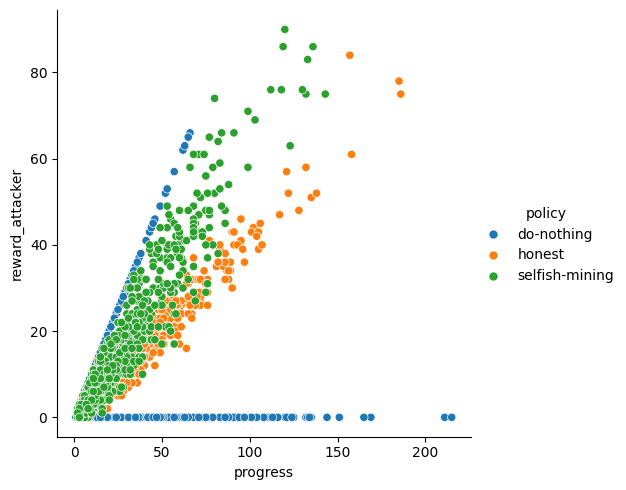

In [5]:
sns.relplot(data=episodes, x="progress", y="reward_attacker", hue="policy")

In [6]:
for policy in episodes.policy.unique():
    subset = episodes.query(f"policy == '{policy}'")
    print(policy, alpha, (subset.reward_attacker / subset.progress).mean())

do-nothing 0.42 0.1327683615819209
honest 0.42 0.4211439049818518
selfish-mining 0.42 0.5710770885369654
